In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)  
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def palette(LED):
    if LED == 'G':
        c = 'green'
    elif LED == 'R':
        c = '#E24A33'
    else:
        c = '#348ABD'
    return c 

# Check multiple file

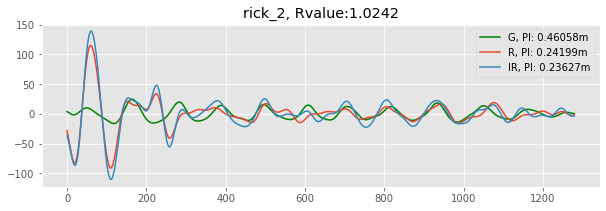

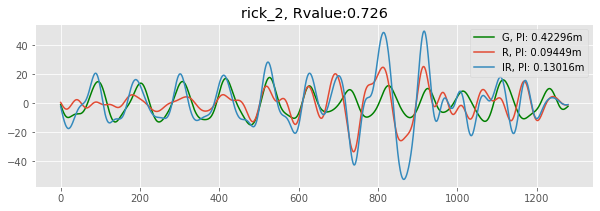

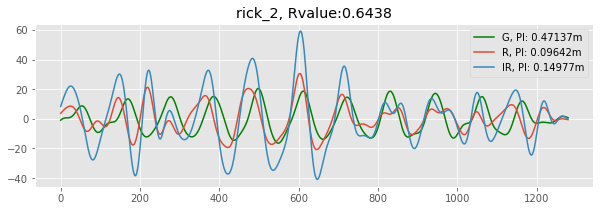

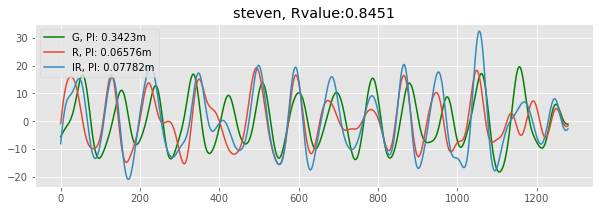

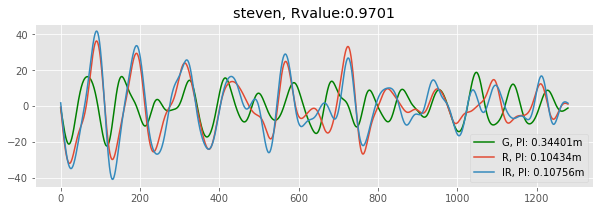

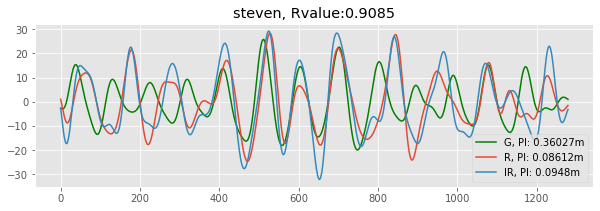

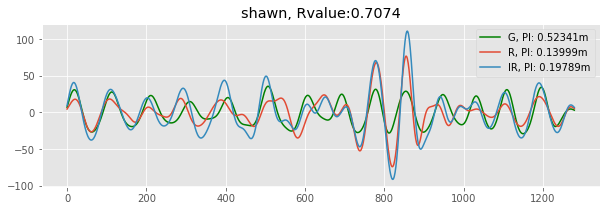

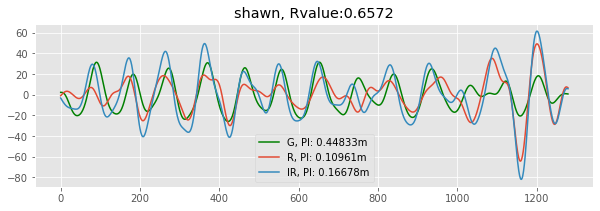

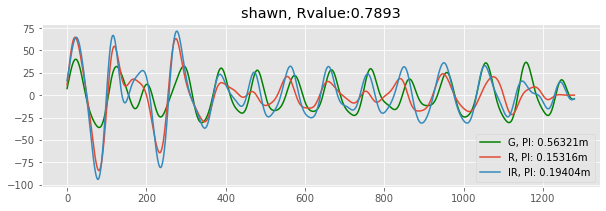

In [11]:


#new format, all data in one package
# folder = 'test/new_format'
# subjects = ['rick']

folder = 'test/spo2'
# subjects = ['rick_f', 'rick_2']
subjects = ['rick_2', 'steven', 'shawn']
# subjects = ['steven']

'''overall parameters '''
# K1 = 99.813
# K2 = -4.615 
# K1 = 121.12
# K2 = -51.77
K1 = 114.21
K2 = -39.41



sr = 128
window = sr*10

# Filter parameters
order = 4
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, order)
lp_b, lp_a = sp.lp_filter(3, sr, order)

LEDS= ['G', 'R', 'IR']
vital_sign={
    'subject':[],
    'HR':[],
    'ppg_HR':[],
    'spo2':[],
    'Rvalue':[],
    'R_PI':[],
    'IR_PI':[]
}

for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data", 'stark', folder, file_name)
    data = file_read.csv_reader(full_file_path)
    # ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    # ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    
    start_sec = 4
    step_sec = 10
    end_sec = 30

    for start_sec in range(start_sec, end_sec, step_sec):
        PI_list={head:[] for head in LEDS}
        PPG_LIST={head:[] for head in LEDS}
        
        
        s1 = start_sec*sr
        s2 = s1+window 

        ecg_sample = data['ecg'][s1:s2]
        ecg_proc = ecg.ecg_preprocess(ecg_sample, sr)
        ecg_proc = np.array(ecg_proc)
        ecg_hr_list, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)
        ecg_hr = np.mean(ecg_hr_list)
        vital_sign['subject'].append(subject)
        vital_sign['HR'].append(ecg_hr)
        
        for LED in LEDS:
            ppg_sample = data[LED][s1:s2]

            # -------------------------------------------------------------
            # Preprocessing
            # include following step
            # 1. flip up and down (if flip=1)
            # 2. bandpass filter
            # filt_ppg = sp.ppg_preprocess(ppg_sample, sr, norm=1,flip=1)
            
            '''
            Perfusion index
            '''
            PPG_AC = signal.filtfilt(bp_b,bp_a, ppg_sample)
            PPG_DC = signal.filtfilt(lp_b,lp_a, ppg_sample)
            
            PPG_LIST[LED] = PPG_AC
            
            # filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
            # filt_G2 = filt_G2 + abs(min(filt_G2))
            # filt_G2 = sp.flip_up_down(G2_sample)
            ''' Heart rate '''
            pks_loc, trs_loc= sp.find_peak_valley(sr, PPG_AC)
            NN = np.diff(pks_loc)/sr
            ppg_hr = np.mean(60/NN)

            # vital_sign[LED+'_HR'].append(ppg_hr)
            
            PI = RMS_amp(PPG_AC/PPG_DC)
            
            PI_list[LED]=PI
            
        # PI_LIST.sort(reverse=True)
        avg_ppg= (PPG_LIST['R'] + PPG_LIST['IR'])/2
        pks_loc, trs_loc= sp.find_peak_valley(sr, avg_ppg)
        NN = np.diff(pks_loc)/sr
        avg_hr = np.mean(60/NN)
        vital_sign['ppg_HR'].append(avg_hr)
        
        R_value = PI_list['R']/PI_list['IR']
        spo2 = K1+ K2*(R_value)
        vital_sign['spo2'].append(spo2)
        vital_sign['Rvalue'].append(R_value)
        vital_sign['R_PI'].append(PI_list['R'])
        vital_sign['IR_PI'].append(PI_list['IR'])
        
        '''Plot ecg '''
        # plt.figure(figsize=(10,4))
        # plt.title(ecg_hr)
        # plt.plot(ecg_proc)
        # plt.plot(rpeak, ecg_proc[rpeak], '*')
        
        '''Plot IR  '''
        # filt_IR= np.array(PPG_LIST['IR'])
        # pks_loc, trs_loc= sp.find_peak_valley(sr, filt_IR)
        # plt.figure(figsize=(12,4))
        # plt.plot(filt_IR, label='IR', color=palette('IR'))
        # plt.title(file_name +', ' +  str(start_sec) +':'+ str(start_sec+step_sec))
        
        
        plt.figure(figsize=(10,3))
        plt.title('{}, Rvalue:{}'.format(subject, np.round(R_value, 4)))
        for LED in LEDS:
            label_str = LED  + ', PI: '+ str(np.round(PI_list[LED]*1000,5)) + 'm'
            plt.plot(PPG_LIST[LED], label=label_str, color=palette(LED))
        plt.legend()
        
        
        # plt.plot(pks_loc, filt_IR[pks_loc], '*')
        # plt.plot(trs_loc, filt_IR[trs_loc], '*')
        
        
        # fig = plt.figure(figsize = (21 ,4))
        # ax1 = fig.add_subplot(131)
        # ax2 = fig.add_subplot(132)
        # ax3 = fig.add_subplot(133)
        
        # ax1.set_title(file_name +', ' +  str(start_sec) +':'+ str(start_sec+step_sec))
        # for LED in LEDS:
        #     label_str = LED  + ', PI: '+ str(np.round(PI_list[LED]*1000,5)) + 'm'
        #     ax1.plot(PPG_LIST[LED], label=label_str, color=palette(LED))
        # ax1.legend()
        
        # ax2.plot(ecg_sample)
        
        # ax3.set_title('ACC')
        # ax3.plot(data['accX'][s1:s2], label='accX')
        # ax3.plot(data['accY'][s1:s2], label='accY')
        # ax3.plot(data['accZ'][s1:s2], label='accZ')
        # ax3.set_ylim(-1,1)
        # ax3.legend()
        
        # bar plot for display perfusion index in each LEDs
        # plt.figure()
        x = np.arange(len(LEDS))
        width = 0.5
        # plt.bar(x, [PI_list[i] for i in PI_list], width, bottom=None, align='center',
        #         color=['green','#E24A33', '#348ABD' ], label='chest')
        # plt.bar(x+width, PI_LIST, width=0.3, bottom=None, align='center',
        #         color=['limegreen','coral', 'skyblue' ], label='finger')

        # plt.xticks(x, LEDS, fontsize=12)
        # plt.xlabel('LED')
        # plt.ylabel('PI')
        # plt.title(file_name)
        # plt.legend(bbox_to_anchor=(1,1), loc='upper left')
        # plt.show()

In [12]:
import pandas as pd

pd.DataFrame(vital_sign)
# vital_sign

,subject,HR,ppg_HR,spo2,Rvalue,R_PI,IR_PI
0,rick_2,69.830552,46.732006,74.894380,0.997605,0.000314,0.000314
1,rick_2,74.711547,78.780010,83.623881,0.776100,0.000151,0.000195
2,rick_2,69.445984,62.886775,85.875266,0.718973,0.000140,0.000194
3,rick_2,70.562391,91.334867,81.635428,0.826556,0.000135,0.000164
4,rick_2,70.814526,68.552122,83.228974,0.786121,0.000126,0.000160
5,steven,83.798146,69.538242,74.571323,1.005803,0.000145,0.000145
6,steven,85.446361,60.360039,71.084850,1.094269,0.000159,0.000146
7,steven,81.457987,63.111632,76.031435,0.968753,0.000143,0.000147
8,steven,83.956994,59.141215,77.470337,0.932242,0.000164,0.000176
9,steven,80.747563,47.316534,78.191779,0.913936,0.000291,0.000319


In [10]:

'''
Take the range of the R value to mapping the normal range of spo2
spo2 = k1 + k2*R (R is a negative number)

100 = k1 + k2*0.55
98 = k1 + k2*1.22
solve k1 = 101.64179104 and k2 = 2.98507463
'''

A = np.array([ [1,-0.55], [1,-1.22] ])
b = np.array([100,98])
z = np.linalg.solve(A,b)
print('Regression parameters for oxygen saturation: ')
print('k1={}, k2={}'.format(z[0], z[1]))
print('-'*50)

print('Parameters of bandpass and low pass filter')
print('sample rate:{}, order:{}'.format(sr, order))

print('low pass b:', list(lp_b))
print('low pass a:', list(lp_a))




Regression parameters for oxygen saturation: 
k1=101.64179104477611, k2=2.985074626865672
--------------------------------------------------
Parameters of bandpass and low pass filter
sample rate:128
low pass b: [2.441956529838341e-05, 9.767826119353363e-05, 0.00014651739179030046, 9.767826119353363e-05, 2.441956529838341e-05]
low pass a: [1.0, -3.615352702016197, 4.9183157191391045, -2.982871345869221, 0.6802990417910879]


# Compare two test item

../../data/stark\test/current_test\ryan_UC_10mA
../../data/stark\test/current_test\ryan_UC_20mA


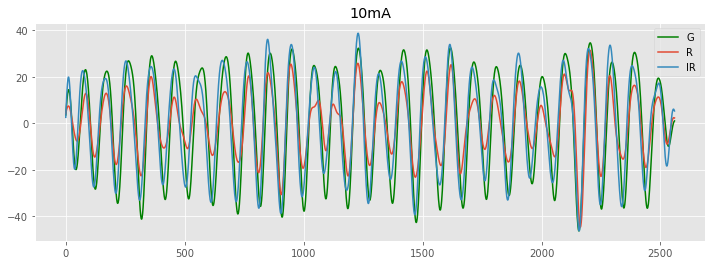

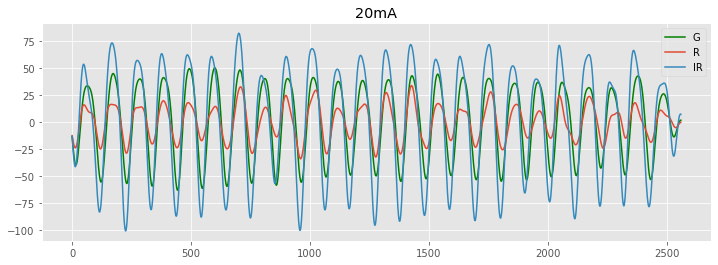

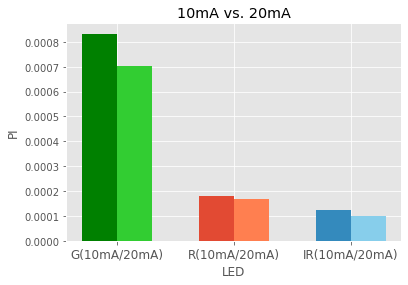

In [16]:


folder = "test/current_test"
subjects = ['ryan_UC_10mA', 'ryan_UC_20mA']

test_item= ['10mA', '20mA']
test_name = test_item
# test_name = ['Transparent lens', 'Printing lens']

start_sec = 8

# sampling
sr =128
window = sr*20
    

# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)

LEDS= ['G','R', 'IR']


PI_1 = []
PI_2 = []
cnt = 0
for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data/stark", folder, file_name)
    ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    
    print(full_file_path)
    s1 = start_sec*sr
    s2 = s1+window 
    
    PPG_LIST={head:[] for head in LEDS}
    
    for LED in LEDS:
        ppg_sample = ppg_data[LED][s1:s2]

        # -------------------------------------------------------------
        # Preprocessing
        # include following step
        # 1. flip up and down (if flip=1)
        # 2. bandpass filter
        # 3. normalize (if norm=1)

        filt_ppg = signal.filtfilt(b,a, sp.flip_up_down(ppg_sample))
        PPG_LIST[LED] = filt_ppg
        # filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
        # filt_G2 = filt_G2 + abs(min(filt_G2))
        # filt_G2 = sp.flip_up_down(G2_sample)
    
    
        '''
        Perfusion index
        '''
        PPG_AC = signal.filtfilt(bp_b,bp_a, ppg_sample)
        PPG_DC = signal.filtfilt(bp_b,bp_a, ppg_sample)
        
        PI = RMS_amp(PPG_AC/PPG_DC)
        
        if cnt == 0:
            PI_1.append(PI)
        else:
            PI_2.append(PI)


    # plot filtered ppg
    plt.figure(figsize=(12,4))
    plt.title(test_name[cnt])

    for LED in LEDS:
        plt.plot(PPG_LIST[LED], label=LED, color=palette(LED))
    plt.legend()
    
    cnt +=1

    

'''
Compare PI in bar plot
'''
plt.figure()
x = np.arange(len(LEDS))
width = 0.3


# sort array
PI_1.sort(reverse=True)
PI_2.sort(reverse=True)


plt.bar(x, PI_1, width, bottom=None, align='center',
        color=['green','#E24A33', '#348ABD' ], label=test_name[0])
plt.bar(x+width, PI_2, width=0.3, bottom=None, align='center',
        color=['limegreen','coral', 'skyblue' ], label=test_name[1])

label_str = '(' + test_item[0] + '/' + test_item[1] + ')'
x_label = [x + label_str for x in LEDS ]
plt.xticks(x+width/2, x_label, fontsize=12)
plt.xlabel('LED')
plt.ylabel('PI')
plt.title(test_name[0] + ' vs. ' +  test_name[1])
# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

